Q3 Daniel Lin 322594508

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

cat_image = cv2.imread('cat.jpg', cv2.IMREAD_GRAYSCALE)

****************** functions from previous questions that i will reuse: ******************

In [8]:
def manual_convolution(image, kernel):
    image_height, image_width = image.shape
    kernel_height, kernel_width = kernel.shape

    pad_height = kernel_height // 2
    pad_width = kernel_width // 2

    padded_image = np.zeros((image_height + 2 * pad_height, image_width + 2 * pad_width))
    padded_image[pad_height:pad_height + image_height, pad_width:pad_width + image_width] = image

    output_image = np.zeros_like(image, dtype=np.float64)

    for i in range(image_height):
        for j in range(image_width):
            region = padded_image[i:i + kernel_height, j:j + kernel_width]
            output_image[i, j] = np.sum(region * kernel)

    return output_image


def fix_image(image):
    clipped = np.clip(image, 0, 255)
    return clipped.astype(np.uint8)


def create_gaussian_kernel(size, sigma):
    distances_from_center = np.linspace(-(size // 2), size // 2, size)
    horizontal_distance_from_center, vertical_distance_from_center = np.meshgrid(distances_from_center, distances_from_center)

    horizontal_distance_squared = horizontal_distance_from_center ** 2
    vertical_distance_squared = vertical_distance_from_center ** 2

    distance_from_center_squared = (horizontal_distance_squared + vertical_distance_squared)
    denominator = 2 * (sigma ** 2)
    kernel = np.exp(-distance_from_center_squared / denominator)

    return kernel / np.sum(kernel)


Q3.1

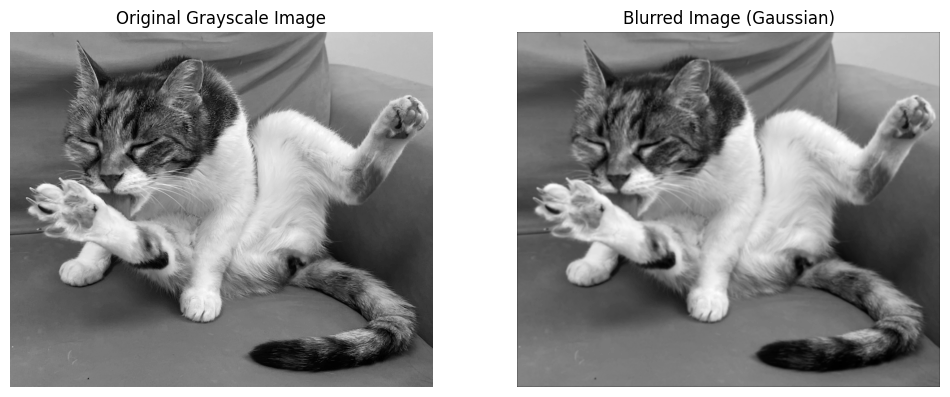

In [9]:
gaussian_kernel = create_gaussian_kernel(5,1)
canny_result_image = manual_convolution(cat_image, gaussian_kernel)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(cat_image, cmap='gray')
plt.title("Original Grayscale Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(fix_image(canny_result_image), cmap='gray')
plt.title("Blurred Image (Gaussian)")
plt.axis('off')

plt.show()

noise reduction is critical because the calculation of the edges is so sensitive, that if we won't use noise reduction it will recognize the noise as a false edges

Q3.2

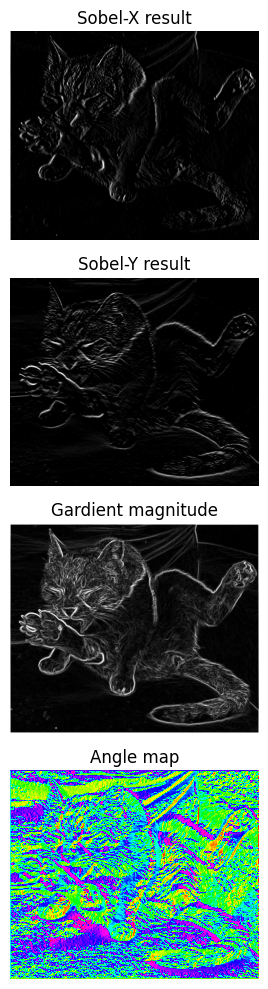

In [15]:
sobel_x_kernel = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
], dtype=np.float64)

sobel_y_kernel = np.array([
    [-1, -2, -1],
    [0,  0,  0],
    [1,  2,  1]
], dtype=np.float64)

result_sobel_x = manual_convolution(canny_result_image, sobel_x_kernel)
result_sobel_y = manual_convolution(canny_result_image, sobel_y_kernel)

G_x = manual_convolution(canny_result_image, sobel_x_kernel)
G_y = manual_convolution(canny_result_image, sobel_y_kernel)
edge_strength = np.sqrt(np.square(G_x) + np.square(G_y))
edge_direction = np.arctan2(G_y, G_x)

plt.figure(figsize=(16, 10))

plt.subplot(4, 1, 1)
plt.imshow(fix_image(G_x), cmap='gray')
plt.title("Sobel-X result")
plt.axis('off')

plt.subplot(4, 1, 2)
plt.imshow(fix_image(G_y), cmap='gray')
plt.title("Sobel-Y result")
plt.axis('off')

plt.subplot(4, 1, 3)
plt.imshow(fix_image(edge_strength), cmap='gray')
plt.title("Gardient magnitude")
plt.axis('off')

plt.subplot(4, 1, 4)
plt.imshow(edge_direction, cmap='hsv')
plt.title("Angle map")
plt.axis('off')

plt.tight_layout()
plt.show()

canny_result_image = edge_strength